In [4]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
# !pip install numpy matplotlib spacy torchtext seaborn
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math,copy,time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk") 
# seaborn只在最后可视化self-attention的时候用到，
# 可以先不管或者注释掉这两行
%matplotlib inline

In [5]:
class Embeddings(nn.Module):
  def __init__(self,d_model,vocab):
    #d_model=512, vocab=当前语言的词表大小
    super(Embeddings,self).__init__()
    self.lut=nn.Embedding(vocab,d_model) 
    # one-hot转词嵌入，这里有一个待训练的矩阵E，大小是vocab*d_model
    self.d_model=d_model # 512
  def forward(self,x): 
     # x ~ (batch.size, sequence.length, one-hot), 
     #one-hot大小=vocab，当前语言的词表大小
     return self.lut(x)*math.sqrt(self.d_model) 
     # 得到的10*512词嵌入矩阵，主动乘以sqrt(512)=22.6，
     #这里我做了一些对比，感觉这个乘以sqrt(512)没啥用… 求反驳。
     #这里的输出的tensor大小类似于(batch.size, sequence.length, 512)

In [6]:
class PositionalEncoding(nn.Module): 
  "Implement the PE function." 
  def __init__(self, d_model, dropout, max_len=5000): 
    #d_model=512,dropout=0.1,
    #max_len=5000代表事先准备好长度为5000的序列的位置编码，其实没必要，
    #一般100或者200足够了。
    super(PositionalEncoding, self).__init__() 
    self.dropout = nn.Dropout(p=dropout) 

    # Compute the positional encodings once in log space. 
    pe = torch.zeros(max_len, d_model) 
    #(5000,512)矩阵，保持每个位置的位置编码，一共5000个位置，
    #每个位置用一个512维度向量来表示其位置编码
    position = torch.arange(0, max_len).unsqueeze(1) 
    # (5000) -> (5000,1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * 
      -(math.log(10000.0) / d_model)) 
      # (0,2,…, 4998)一共准备2500个值，供sin, cos调用
    pe[:, 0::2] = torch.sin(position * div_term) # 偶数下标的位置
    pe[:, 1::2] = torch.cos(position * div_term) # 奇数下标的位置
    pe = pe.unsqueeze(0) 
    # (5000, 512) -> (1, 5000, 512) 为batch.size留出位置
    self.register_buffer('pe', pe) 
  def forward(self, x): 
    x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False) 
    # 接受1.Embeddings的词嵌入结果x，
    #然后把自己的位置编码pe，封装成torch的Variable(不需要梯度)，加上去。
    #例如，假设x是(30,10,512)的一个tensor，
    #30是batch.size, 10是该batch的序列长度, 512是每个词的词嵌入向量；
    #则该行代码的第二项是(1, min(10, 5000), 512)=(1,10,512)，
    #在具体相加的时候，会扩展(1,10,512)为(30,10,512)，
    #保证一个batch中的30个序列，都使用（叠加）一样的位置编码。
    return self.dropout(x) # 增加一次dropout操作
# 注意，位置编码不会更新，是写死的，所以这个class里面没有可训练的参数。

In [8]:
def attention(query, key, value, mask=None, dropout=None): 
# query, key, value的形状类似于(30, 8, 10, 64), (30, 8, 11, 64), 
#(30, 8, 11, 64)，例如30是batch.size，即当前batch中有多少一个序列；
# 8=head.num，注意力头的个数；
# 10=目标序列中词的个数，64是每个词对应的向量表示；
# 11=源语言序列传过来的memory中，当前序列的词的个数，
# 64是每个词对应的向量表示。
# 类似于，这里假定query来自target language sequence；
# key和value都来自source language sequence.
  "Compute 'Scaled Dot Product Attention'" 
  d_k = query.size(-1) # 64=d_k
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) 
    # 先是(30,8,10,64)和(30, 8, 64, 11)相乘，
    #（注意是最后两个维度相乘）得到(30,8,10,11)，
    #代表10个目标语言序列中每个词和11个源语言序列的分别的“亲密度”。
    #然后除以sqrt(d_k)=8，防止过大的亲密度。
    #这里的scores的shape是(30, 8, 10, 11)
  if mask is not None: 
    scores = scores.masked_fill(mask == 0, -1e9) 
    #使用mask，对已经计算好的scores，按照mask矩阵，填-1e9，
    #然后在下一步计算softmax的时候，被设置成-1e9的数对应的值~0,被忽视
  p_attn = F.softmax(scores, dim = -1) 
    #对scores的最后一个维度执行softmax，得到的还是一个tensor, 
    #(30, 8, 10, 11)
  if dropout is not None: 
    p_attn = dropout(p_attn) #执行一次dropout
  return torch.matmul(p_attn, value), p_attn
#返回的第一项，是(30,8,10, 11)乘以（最后两个维度相乘）
#value=(30,8,11,64)，得到的tensor是(30,8,10,64)，
#和query的最初的形状一样。另外，返回p_attn，形状为(30,8,10,11). 
#注意，这里返回p_attn主要是用来可视化显示多头注意力机制。

In [11]:
class MultiHeadedAttention(nn.Module): 
  def __init__(self, h, d_model, dropout=0.1): 
    # h=8, d_model=512
    "Take in model size and number of heads." 
    super(MultiHeadedAttention, self).__init__() 
    assert d_model % h == 0 # We assume d_v always equals d_k 512%8=0
    self.d_k = d_model // h # d_k=512//8=64
    self.h = h #8
    self.linears = clones(nn.Linear(d_model, d_model), 4) 
    #定义四个Linear networks, 每个的大小是(512, 512)的，
    #每个Linear network里面有两类可训练参数，Weights，
    #其大小为512*512，以及biases，其大小为512=d_model。

    self.attn = None 
    self.dropout = nn.Dropout(p=dropout)
  def forward(self, query, key, value, mask=None): 
   # 注意，输入query的形状类似于(30, 10, 512)，
   # key.size() ~ (30, 11, 512), 
   #以及value.size() ~ (30, 11, 512)
    
    if mask is not None: # Same mask applied to all h heads. 
      mask = mask.unsqueeze(1) # mask下回细细分解。
    nbatches = query.size(0) #e.g., nbatches=30
    # 1) Do all the linear projections in batch from 
    #d_model => h x d_k 
    query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k)
      .transpose(1, 2) for l, x in 
      zip(self.linears, (query, key, value))] 
      # 这里是前三个Linear Networks的具体应用，
      #例如query=(30,10, 512) -> Linear network -> (30, 10, 512) 
      #-> view -> (30,10, 8, 64) -> transpose(1,2) -> (30, 8, 10, 64)
      #，其他的key和value也是类似地，
      #从(30, 11, 512) -> (30, 8, 11, 64)。
    # 2) Apply attention on all the projected vectors in batch. 
    x, self.attn = attention(query, key, value, mask=mask, 
      dropout=self.dropout) 
      #调用上面定义好的attention函数，输出的x形状为(30, 8, 10, 64)；
      #attn的形状为(30, 8, 10=target.seq.len, 11=src.seq.len)
    # 3) "Concat" using a view and apply a final linear. 
    x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k) 
      # x ~ (30, 8, 10, 64) -> transpose(1,2) -> 
      #(30, 10, 8, 64) -> contiguous() and view -> 
      #(30, 10, 8*64) = (30, 10, 512)
    return self.linears[-1](x) 
    #执行第四个Linear network，把(30, 10, 512)经过一次linear network，
    #得到(30, 10, 512).

In [12]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        # features=d_model=512, eps=epsilon 用于分母的非0化平滑
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        # a_2 是一个可训练参数向量，(512)
        self.b_2 = nn.Parameter(torch.zeros(features))
        # b_2 也是一个可训练参数向量, (512)
        self.eps = eps

    def forward(self, x):
        # x 的形状为(batch.size, sequence.len, 512)
        mean = x.mean(-1, keepdim=True) 
        # 对x的最后一个维度，取平均值，得到tensor (batch.size, seq.len)
        std = x.std(-1, keepdim=True)
        # 对x的最后一个维度，取标准方差，得(batch.size, seq.len)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
        # 本质上类似于（x-mean)/std，不过这里加入了两个可训练向量
        # a_2 and b_2，以及分母上增加一个极小值epsilon，用来防止std为0
        # 的时候的除法溢出

In [13]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        # size=d_model=512; dropout=0.1
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size) # (512)，用来定义a_2和b_2
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the "
        "same size."
        # x is alike (batch.size, sequence.len, 512)
        # sublayer是一个具体的MultiHeadAttention
        #或者PositionwiseFeedForward对象
        return x + self.dropout(sublayer(self.norm(x)))
        # x (30, 10, 512) -> norm (LayerNorm) -> (30, 10, 512)
        # -> sublayer (MultiHeadAttention or PositionwiseFeedForward)
        # -> (30, 10, 512) -> dropout -> (30, 10, 512)
        
        # 然后输入的x（没有走sublayer) + 上面的结果，
        #即实现了残差相加的功能

In [14]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        # d_model = 512
        # d_ff = 2048 = 512*4
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        # 构建第一个全连接层，(512, 2048)，其中有两种可训练参数：
        # weights矩阵，(512, 2048)，以及
        # biases偏移向量, (2048)
        self.w_2 = nn.Linear(d_ff, d_model)
        # 构建第二个全连接层, (2048, 512)，两种可训练参数：
        # weights矩阵，(2048, 512)，以及
        # biases偏移向量, (512)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape = (batch.size, sequence.len, 512)
        # 例如, (30, 10, 512)
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
        # x (30, 10, 512) -> self.w_1 -> (30, 10, 2048)
        # -> relu -> (30, 10, 2048) 
        # -> dropout -> (30, 10, 2048)
        # -> self.w_2 -> (30, 10, 512)是输出的shape

In [15]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [16]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and "
    "feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        # size=d_model=512
        # self_attn = MultiHeadAttention对象, first sublayer
        # feed_forward = PositionwiseFeedForward对象，second sublayer
        # dropout = 0.1 (e.g.)
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        # 使用深度克隆方法，完整地复制出来两个SublayerConnection
        self.size = size # 512

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        # x shape = (30, 10, 512)
        # mask 是(batch.size, 10,10)的矩阵，类似于当前一个词w，有哪些词是w可见的
        # 源语言的序列的话，所有其他词都可见，除了"<blank>"这样的填充；
        # 目标语言的序列的话，所有w的左边的词，都可见。
        x = self.sublayer[0](x, 
          lambda x: self.self_attn(x, x, x, mask))
        # x (30, 10, 512) -> self_attn (MultiHeadAttention) 
        # shape is same (30, 10, 512) -> SublayerConnection 
        # -> (30, 10, 512)
        return self.sublayer[1](x, self.feed_forward)
        # x 和feed_forward对象一起，给第二个SublayerConnection

In [17]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        # layer = one EncoderLayer object, N=6
        super(Encoder, self).__init__()
        self.layers = clones(layer, N) 
        # 深copy，N=6，
        self.norm = LayerNorm(layer.size)
        # 定义一个LayerNorm，layer.size=d_model=512
        # 其中有两个可训练参数a_2和b_2

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        # x is alike (30, 10, 512)
        # (batch.size, sequence.len, d_model)
        # mask是类似于(batch.size, 10, 10)的矩阵
        for layer in self.layers:
            x = layer(x, mask)
            # 进行六次EncoderLayer操作
        return self.norm(x)
        # 最后做一次LayerNorm，最后的输出也是(30, 10, 512) shape

In [18]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, "
    "and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, 
      feed_forward, dropout):
      # size = d_model=512,
      # self_attn = one MultiHeadAttention object，目标语言序列的
      # src_attn = second MultiHeadAttention object, 目标语言序列
      # 和源语言序列之间的
      # feed_forward 一个全连接层
      # dropout = 0.1
        super(DecoderLayer, self).__init__()
        self.size = size # 512
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        # 需要三个SublayerConnection, 分别在
        # self.self_attn, self.src_attn, 和self.feed_forward
        # 的后边

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory # (batch.size, sequence.len, 512) 
        # 来自源语言序列的Encoder之后的输出，作为memory
        # 供目标语言的序列检索匹配：（类似于alignment in SMT)
        x = self.sublayer[0](x, 
          lambda x: self.self_attn(x, x, x, tgt_mask))
        # 通过一个匿名函数，来实现目标序列的自注意力编码
        # 结果扔给sublayer[0]:SublayerConnection
        x = self.sublayer[1](x, 
          lambda x: self.src_attn(x, m, m, src_mask))
        # 通过第二个匿名函数，来实现目标序列和源序列的注意力计算
        # 结果扔给sublayer[1]:SublayerConnection
        return self.sublayer[2](x, self.feed_forward)
        # 走一个全连接层，然后
        # 结果扔给sublayer[2]:SublayerConnection

In [19]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        # layer = DecoderLayer object
        # N = 6
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        # 深度copy六次DecoderLayer
        self.norm = LayerNorm(layer.size)
        # 初始化一个LayerNorm

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
            # 执行六次DecoderLayer
        return self.norm(x)
        # 执行一次LayerNorm

In [20]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        # d_model=512
        # vocab = 目标语言词表大小
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        # 定义一个全连接层，可训练参数个数是(512 * trg_vocab_size) + 
        # trg_vocab_size

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
        # x 类似于 (batch.size, sequence.length, 512)
        # -> proj 全连接层 (30, 10, trg_vocab_size) = logits
        # 对最后一个维度执行log_soft_max
        # 得到(30, 10, trg_vocab_size)

In [21]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. 
    Base for this and many other models.
    """
    def __init__(self, encoder, decoder, 
      src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        # Encoder对象
        self.decoder = decoder
        # Decoder对象
        self.src_embed = src_embed
        # 源语言序列的编码，包括词嵌入和位置编码
        self.tgt_embed = tgt_embed
        # 目标语言序列的编码，包括词嵌入和位置编码
        self.generator = generator
        # 生成器

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
        # 先对源语言序列进行编码，
        # 结果作为memory传递给目标语言的编码器

    def encode(self, src, src_mask):
        # src = (batch.size, seq.length)
        # src_mask 负责对src加掩码
        return self.encoder(self.src_embed(src), src_mask)
        # 对源语言序列进行编码，得到的结果为
        # (batch.size, seq.length, 512)的tensor

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), 
          memory, src_mask, tgt_mask)
        # 对目标语言序列进行编码，得到的结果为
        # (batch.size, seq.length, 512)的tensor

In [23]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    # e.g., size=10
    attn_shape = (1, size, size) # (1, 10, 10)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    # triu: 负责生成一个三角矩阵，k-th对角线以下都是设置为0 
    # 上三角中元素为1.
    
    return torch.from_numpy(subsequent_mask) == 0
    # 反转上面的triu得到的上三角矩阵，修改为下三角矩阵。

In [24]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    # src_vocab = 源语言词表大小
    # tgt_vocab = 目标语言词表大小
    
    c = copy.deepcopy # 对象的深度copy/clone
    attn = MultiHeadedAttention(h, d_model) # 8, 512
    # 构造一个MultiHeadAttention对象
    
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    # 512, 2048, 0.1
    # 构造一个feed forward对象

    position = PositionalEncoding(d_model, dropout)
    # 位置编码

    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))

    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model # EncoderDecoder 对象

In [25]:
tmp_model = make_model(10, 10, 2)
# src_vocab_size = 10
# tgt_vocab_size = 10
# N = 2, number for EncoderLayer and DecoderLayer

for name, param in tmp_model.named_parameters():
    if param.requires_grad:
        print (name, param.data.shape)
    else:
        print ('no gradient necessary', name, param.data.shape)

encoder.layers.0.self_attn.linears.0.weight torch.Size([512, 512])
encoder.layers.0.self_attn.linears.0.bias torch.Size([512])
encoder.layers.0.self_attn.linears.1.weight torch.Size([512, 512])
encoder.layers.0.self_attn.linears.1.bias torch.Size([512])
encoder.layers.0.self_attn.linears.2.weight torch.Size([512, 512])
encoder.layers.0.self_attn.linears.2.bias torch.Size([512])
encoder.layers.0.self_attn.linears.3.weight torch.Size([512, 512])
encoder.layers.0.self_attn.linears.3.bias torch.Size([512])
encoder.layers.0.feed_forward.w_1.weight torch.Size([2048, 512])
encoder.layers.0.feed_forward.w_1.bias torch.Size([2048])
encoder.layers.0.feed_forward.w_2.weight torch.Size([512, 2048])
encoder.layers.0.feed_forward.w_2.bias torch.Size([512])
encoder.layers.0.sublayer.0.norm.a_2 torch.Size([512])
encoder.layers.0.sublayer.0.norm.b_2 torch.Size([512])
encoder.layers.0.sublayer.1.norm.a_2 torch.Size([512])
encoder.layers.0.sublayer.1.norm.b_2 torch.Size([512])
encoder.layers.1.self_attn.

C:\Users\dayan\AppData\Local\Temp\ipykernel_26544\2203205054.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [26]:
tmp_model = make_model(30000, 30000, 6) 
# src_vocab_size=30000, tgt_vocab_size=30000, N=6
#None
for name, param in tmp_model.named_parameters():
    if param.requires_grad:
        print (name, param.data.shape)
    else:
        print ('no gradient necessary', name, param.data.shape)

C:\Users\dayan\AppData\Local\Temp\ipykernel_26544\2203205054.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


encoder.layers.0.self_attn.linears.0.weight torch.Size([512, 512])
encoder.layers.0.self_attn.linears.0.bias torch.Size([512])
encoder.layers.0.self_attn.linears.1.weight torch.Size([512, 512])
encoder.layers.0.self_attn.linears.1.bias torch.Size([512])
encoder.layers.0.self_attn.linears.2.weight torch.Size([512, 512])
encoder.layers.0.self_attn.linears.2.bias torch.Size([512])
encoder.layers.0.self_attn.linears.3.weight torch.Size([512, 512])
encoder.layers.0.self_attn.linears.3.bias torch.Size([512])
encoder.layers.0.feed_forward.w_1.weight torch.Size([2048, 512])
encoder.layers.0.feed_forward.w_1.bias torch.Size([2048])
encoder.layers.0.feed_forward.w_2.weight torch.Size([512, 2048])
encoder.layers.0.feed_forward.w_2.bias torch.Size([512])
encoder.layers.0.sublayer.0.norm.a_2 torch.Size([512])
encoder.layers.0.sublayer.0.norm.b_2 torch.Size([512])
encoder.layers.0.sublayer.1.norm.a_2 torch.Size([512])
encoder.layers.0.sublayer.1.norm.b_2 torch.Size([512])
encoder.layers.1.self_attn.

In [27]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        # src: 源语言序列，(batch.size, src.seq.len)
        # 二维tensor，第一维度是batch.size；第二个维度是源语言句子的长度
        # 例如：[ [2,1,3,4], [2,3,1,4] ]这样的二行四列的，
        # 1-4代表每个单词word的id
        
        # trg: 目标语言序列，默认为空，其shape和src类似
        # (batch.size, trg.seq.len)，
        #二维tensor，第一维度是batch.size；第二个维度是目标语言句子的长度
        # 例如trg=[ [2,1,3,4], [2,3,1,4] ] for a "copy network"
        # (输出序列和输入序列完全相同）
        
        # pad: 源语言和目标语言统一使用的 位置填充符号，'<blank>'
        # 所对应的id，这里默认为0
        # 例如，如果一个source sequence，长度不到4，则在右边补0
        # [1,2] -> [1,2,0,0]
        
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        # src = (batch.size, seq.len) -> != pad -> 
        # (batch.size, seq.len) -> usnqueeze ->
        # (batch.size, 1, seq.len) 相当于在倒数第二个维度扩展
        # e.g., src=[ [2,1,3,4], [2,3,1,4] ]对应的是
        # src_mask=[ [[1,1,1,1], [1,1,1,1]] ]
        if trg is not None:
            self.trg = trg[:, :-1] # 重要
            # trg 相当于目标序列的前N-1个单词的序列
            #（去掉了最后一个词）
            self.trg_y = trg[:, 1:]
            # trg_y 相当于目标序列的后N-1个单词的序列
            # (去掉了第一个词）
            # 目的是(src + trg) 来预测出来(trg_y)，
            # 这个在illustrated transformer中详细图示过。
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        # 这里的tgt类似于：
        #[ [2,1,3], [2,3,1] ] （最初的输入目标序列，分别去掉了最后一个词
        # pad=0, '<blank>'的id编号
        tgt_mask = (tgt != pad).unsqueeze(-2)
        # 得到的tgt_mask类似于
        # tgt_mask = tensor([[[1, 1, 1]],[[1, 1, 1]]], dtype=torch.uint8)
        # shape=(2,1,3)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        # 先看subsequent_mask, 其输入的是tgt.size(-1)=3
        # 这个函数的输出为= tensor([[[1, 0, 0],
        # [1, 1, 0],
        # [1, 1, 1]]], dtype=torch.uint8)
        # type_as 把这个tensor转成tgt_mask.data的type(也是torch.uint8)
        
        # 这样的话，&的两边的tensor分别是(2,1,3), (1,3,3);
        #tgt_mask = tensor([[[1, 1, 1]],[[1, 1, 1]]], dtype=torch.uint8)
        #and
        # tensor([[[1, 0, 0], [1, 1, 0], [1, 1, 1]]], dtype=torch.uint8)
        
        # (2,3,3)就是得到的tensor
        # tgt_mask.data = tensor([[[1, 0, 0],
        # [1, 1, 0],
        # [1, 1, 1]],

        #[[1, 0, 0],
        # [1, 1, 0],
        # [1, 1, 1]]], dtype=torch.uint8)
        return tgt_mask

In [28]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        # optimizer = Adam (Parameter Group 0
        #    amsgrad: False
        #    betas: (0.9, 0.98)
        #    eps: 1e-09
        #    lr: 0
        #    weight_decay: 0
        #)
        self._step = 0
        self.warmup = warmup # e.g., 4000 轮 热身
        self.factor = factor # e.g., 2
        self.model_size = model_size # 512
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate`(learning rate) above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, 
            betas=(0.9, 0.98), eps=1e-9))

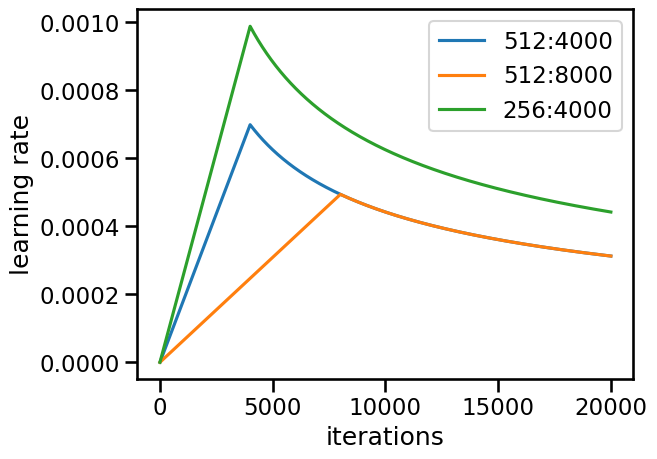

In [29]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), 
  [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
plt.xlabel('iterations')
plt.ylabel('learning rate')
None

In [49]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx # '<blank>' 的id
        self.confidence = 1.0 - smoothing # 自留的概率值、得分 e.g. 0.6
        self.smoothing = smoothing # 均分出去的概率值，得分 e.g. 0.4
        self.size = size # target vocab size 目标语言词表大小
        self.true_dist = None
        
    def forward(self, x, target):
        "in real-world case: 真实情况下"
        #  x的shape为(batch.size * seq.len, target.vocab.size)
        # y的shape是(batch.size * seq.len)
        
        # x=logits，(seq.len, target.vocab.size)
        # 每一行，代表一个位置的词
        # 类似于：假设seq.len=3, target.vocab.size=5
        # x中保存的是log(prob)
        #x = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]])
        
        # target 类似于：
        # target = tensor([2, 1, 0])，torch.size=(3)
        
        assert x.size(1) == self.size # 目标语言词表大小
        true_dist = x.data.clone()
        # true_dist = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
        #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]])
        
        true_dist.fill_(self.smoothing / (self.size - 2))
        # true_dist = tensor([[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        #[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        #[0.1333, 0.1333, 0.1333, 0.1333, 0.1333]])
        
        # 注意，这里分母target.vocab.size-2是因为
        # (1) 最优值 0.6要占一个位置；
        # (2) 填充词 <blank> 要被排除在外
        # 所以被激活的目标语言词表大小就是self.size-2
        
        true_dist.scatter_(1, target.data.unsqueeze(1).long(), self.confidence)
        # target.data.unsqueeze(1) -> 
        # tensor([[2],
        #[1],
        #[0]]); shape=torch.Size([3, 1])  
        # self.confidence = 0.6
        
        # 根据target.data的指示，按照列优先(1)的原则，把0.6这个值
        # 填入true_dist: 因为target.data是2,1,0的内容，
        # 所以，0.6填入第0行的第2列（列号，行号都是0开始）
        # 0.6填入第1行的第1列
        # 0.6填入第2行的第0列：
        # true_dist = tensor([[0.1333, 0.1333, 0.6000, 0.1333, 0.1333],
        #[0.1333, 0.6000, 0.1333, 0.1333, 0.1333],
        #[0.6000, 0.1333, 0.1333, 0.1333, 0.1333]])
          
        true_dist[:, self.padding_idx] = 0
        # true_dist = tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        #[0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        #[0.0000, 0.1333, 0.1333, 0.1333, 0.1333]])
        # 设置true_dist这个tensor的第一列的值全为0
        # 因为这个是填充词'<blank>'所在的id位置，不应该计入
        # 目标词表。需要注意的是，true_dist的每一列，代表目标语言词表
        #中的一个词的id
        
        mask = torch.nonzero(target.data == self.padding_idx)
        # mask = tensor([[2]]), 也就是说，最后一个词 2,1,0中的0，
        # 因为是'<blank>'的id，所以通过上面的一步，把他们找出来
        
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
            # 当target reference序列中有0这个'<blank>'的时候，则需要把
            # 这一行的值都清空。
            # 在一个batch里面的时候，可能两个序列长度不一，所以短的序列需要
            # pad '<blank>'来填充，所以会出现类似于(2,1,0)这样的情况
            # true_dist = tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
            # [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
            # [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
        self.true_dist = true_dist
        return self.criterion(x, 
          Variable(true_dist, requires_grad=False))
          # 这一步就是调用KL loss来计算
          # x = tensor([[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
          #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233],
          #[-20.7233,  -1.6094,  -0.3567,  -2.3026, -20.7233]])
          
          # true_dist=tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
          # [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
          # [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
          # 之间的loss了。细节可以参考我的那篇illustrated transformer

C:\Users\dayan\.conda\envs\py39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


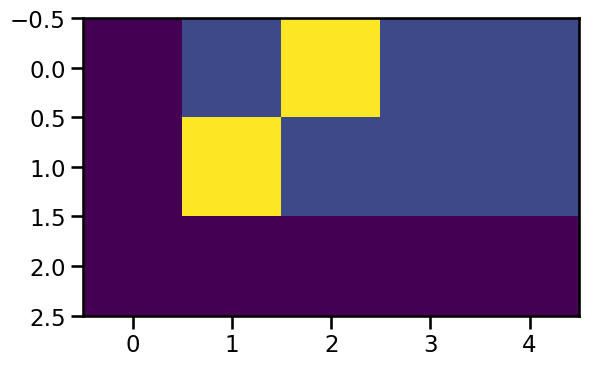

In [50]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4) # trg.vocab.size=5, pad_idx=0, 
# smooth=0.4 and thus confidence=0.6
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
                             # predicted logits tensor
"smooth only and important"
predict = predict.masked_fill(predict == 0, 1e-9) # "smooth only"

v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
#true_dist=tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
#        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
#        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]), 
# true_dist.shape=torch.Size([3, 5])
None

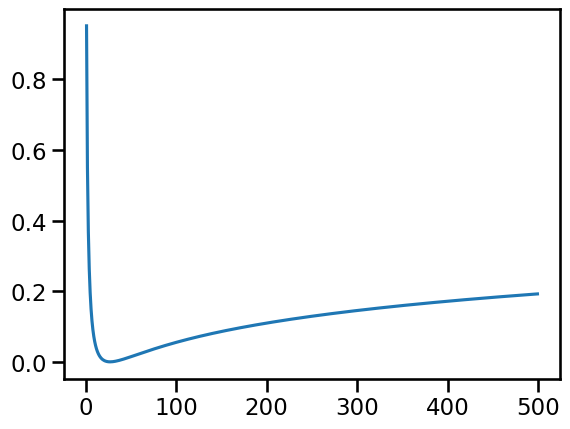

In [51]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0.001, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).item()
plt.plot(np.arange(1, 500), [loss(x) for x in range(1, 500)])
None

In [52]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [53]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator # Generator 对象, linear+softmax
        self.criterion = criterion # LabelSmooth对象，计算loss
        self.opt = opt # NormOpt对象，优化算法对象
        
    def __call__(self, x, y, norm):
        # e.g., x为(2,3,8), batch.size=2, seq.len=3, d_model=8
        # y = tensor([[4, 2, 1],
        #[4, 4, 4]], dtype=torch.int32)
        
        # norm: (y=trg_y中非'<blank>'的token的个数)
        "attention here"
        
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm.item()
        # 变形后，x类似于(batch.size*seq.len, target.vocab.size)
        # y为(target.vocab.size)
        # 然后调用LabelSmooth来计算loss
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        #return loss.data[0] * norm
        "attention here"
        return loss.data.item() * norm.item()

In [54]:
def run_epoch(aepoch, data_iter, model, loss_compute):

    "Standard Training and Logging Function"
    # data_iter = 所有数据的打包
    # model = EncoderDecoder 对象
    # loss_compute = SimpleLossCompute对象
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        # 对每个batch循环
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        # 使用目前的model，对batch.src+batch.trg进行forward
                            
        # e.g.,
        # batch.src (2,4) = tensor([[1, 4, 2, 1],
        # [1, 4, 4, 4]], dtype=torch.int32)
        
        # batch.trg (2,3) = tensor([[1, 4, 2],
        # [1, 4, 4]], dtype=torch.int32)
        
        # batch.src_mask (2,1,4) = tensor([[[1, 1, 1, 1]],
        # [[1, 1, 1, 1]]], dtype=torch.uint8)
        
        # batch.trg_mask (2,3,3) = tensor([[[1, 0, 0],
        # [1, 1, 0],
        # [1, 1, 1]],

        #[[1, 0, 0],
        # [1, 1, 0],
         #[1, 1, 1]]], dtype=torch.uint8)
         
        # and out (2,3,8):
        # out = tensor([[[-0.4749, -0.4887,  0.1245, -0.4042,  0.5301,  
        #   1.7662, -1.6224, 0.5694],
        # [ 0.4683, -0.7813,  0.2845,  0.4464, -0.3088, -0.1751, -1.6643,
        #   1.7303],
         #[-1.1600, -0.2348,  1.0631,  1.3192, -0.9453,  0.3538,  0.7051...                 
        
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        # out和trg_y计算Loss
        # ntokens = 6 (trg_y中非'<blank>'的token的个数)
        # 注意，这里是token,不是unique word
        # 例如[ [ [1, 2, 3], [2,3,4] ]中有6个token,而只有4个unique word
        
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            "attention here 这里隐藏一个bug"
            #print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
            #        (i, loss / batch.ntokens, tokens / elapsed))
            print ('epoch step: {}:{} Loss: {}/{}, tokens per sec: {}/{}'
                    .format(aepoch, i, loss, batch.ntokens, 
                    tokens, elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [58]:
# Train the simple copy task.
V = 11 # here V is the vocab size of source and target languages (sequences)
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.01) # 创建损失函数计算对象
    
#model = make_model(V, V, N=2, d_model=8, d_ff=16, h=2) 
model = make_model(V, V, N=2) 
# EncoderDecoder对象构造
'''
in make_model: src_vocab_size=11, tgt_vocab_size=11, 
    N=2, d_model=512, d_ff=2048, h=8, dropout=0.1
'''

model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), 
        lr=0, betas=(0.9, 0.98), eps=1e-9))
# 模型最优化算法的对象

C:\Users\dayan\AppData\Local\Temp\ipykernel_26544\2203205054.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [59]:
lossfun = SimpleLossCompute(model.generator, 
        criterion, model_opt)
if True:
    print ('start model training...')
    for epoch in range(10):
        print ('epoch={}, training...'.format(epoch))
        model.train() # set the model into "train" mode
        # 设置模型进入训练模式
        
        #lossfun = SimpleLossCompute(model.generator, 
        #    criterion, model_opt) # 不需要在这里定义lossfun
        
        run_epoch(epoch, data_gen(V, 30, 20), model, lossfun)
        # 重新构造一批数据，并执行训练
        
        model.eval() # 模型进入evaluation模式 (dropout，反向传播无效）
        print ('evaluating...')
        print(run_epoch(epoch, data_gen(V, 30, 5), model, 
                        SimpleLossCompute(model.generator, 
                        criterion, None)))
        # 这里None表示优化函数为None，所以不进行参数更新 

start model training...
epoch=0, training...
epoch step: 0:1 Loss: 861.1939287185669/270, tokens per sec: 540/0.8410985469818115
evaluating...
epoch step: 0:1 Loss: 516.0471224784851/270, tokens per sec: 540/0.6737782955169678
tensor(1.9037)
epoch=1, training...
epoch step: 1:1 Loss: 512.295173406601/270, tokens per sec: 540/0.8263473510742188
evaluating...
epoch step: 1:1 Loss: 474.35638904571533/270, tokens per sec: 540/0.6029646396636963
tensor(1.7227)
epoch=2, training...
epoch step: 2:1 Loss: 492.8777289390564/270, tokens per sec: 540/0.8480885028839111
evaluating...
epoch step: 2:1 Loss: 381.42473459243774/270, tokens per sec: 540/0.7424676418304443
tensor(1.4380)
epoch=3, training...
epoch step: 3:1 Loss: 426.50007247924805/270, tokens per sec: 540/0.8815066814422607
evaluating...
epoch step: 3:1 Loss: 288.0887532234192/270, tokens per sec: 540/0.6892383098602295
tensor(1.1435)
epoch=4, training...
epoch step: 4:1 Loss: 330.6343603134155/270, tokens per sec: 540/1.12625694274902

In [61]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask) 
    # 源语言的一个batch
    # 执行encode编码工作，得到memory 
    # shape=(batch.size, src.seq.len, d_model)
    
    # src = (1,4), batch.size=1, seq.len=4
    # src_mask = (1,1,4) with all ones
    # start_symbol=1
    
    print ('memory={}, memory.shape={}'.format(memory, 
        memory.shape))
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    # 最初ys=[[1]], size=(1,1); 这里start_symbol=1
    print ('ys={}, ys.shape={}'.format(ys, ys.shape))
    for i in range(max_len-1): # max_len = 5
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        # memory, (1, 4, 8), 1=batch.size, 4=src.seq.len, 8=d_model
        # src_mask = (1,1,4) with all ones
        # out, (1, 1, 8), 1=batch.size, 1=seq.len, 8=d_model                             
        print ('out={}, out.shape={}'.format(out, out.shape))
        prob = model.generator(out[:, -1]) 
        # pick the right-most word
        # (1=batch.size,8) -> generator -> prob=(1,5) 5=trg.vocab.size
        # -1 for ? only look at the final (out) word's vector
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        # word id of "next_word"
        ys = torch.cat([ys, 
          torch.ones(1, 1).type_as(src.data).fill_(next_word)], 
          dim=1)
        # ys is in shape of (1,2) now, i.e., 2 words in current seq
    return ys

if True:
    model.eval()
    src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]))
    src_mask = Variable(torch.ones(1, 1, 10))
    print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

memory=tensor([[[ 0.9922, -1.1210,  1.8408,  ..., -0.7818,  0.9631, -0.2557],
         [ 0.3441, -1.1436,  1.3865,  ...,  1.5489, -0.2930, -2.0058],
         [ 1.2726, -3.5400,  0.0550,  ..., -1.1153,  0.0603, -0.0068],
         ...,
         [ 0.0620,  0.9202, -1.6916,  ..., -0.3031, -0.2538,  0.4937],
         [ 1.6376,  0.0452,  1.2741,  ...,  0.1952,  0.5422, -0.0835],
         [ 1.1937,  0.0692,  1.4020,  ..., -0.0377, -0.2202, -1.0801]]],
       grad_fn=<AddBackward0>), memory.shape=torch.Size([1, 10, 512])
ys=tensor([[1]]), ys.shape=torch.Size([1, 1])
out=tensor([[[ 1.8272e+00, -9.9720e-01,  4.1118e-01, -1.1957e-01,  3.6171e-01,
           4.6739e-01,  1.7287e+00,  4.8791e-01, -1.8367e+00,  4.6678e-02,
          -3.2218e-01,  4.4384e-02,  3.3944e-01,  3.4322e-01, -1.2555e+00,
           8.9413e-01, -4.8681e-01,  6.5548e-01,  5.0356e-01,  1.7436e+00,
          -8.9444e-01, -1.1160e+00, -1.2079e+00, -9.5165e-01, -2.2192e-02,
          -1.5827e-01,  2.6746e-02,  8.3797e-01,  2.9386